In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

In [ ]:
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.RandomRotation(10), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = datasets.CIFAR10('data', download = True, train = True, transform = transform)
testset = datasets.CIFAR10('data', download = True, train = False, transform = transform)

trainset_len = len(trainset)
validation_size = 0.2
indices = list(i for i in range(trainset_len))
np.random.shuffle(indices)
split = int(np.floor(trainset_len * validation_size))
train_indices, valid_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)

train_loader = torch.utils.data.DataLoader(trainset, batch_size = 20, sampler = train_sampler)
valid_loader = torch.utils.data.DataLoader(trainset, batch_size = 20, sampler = valid_sampler)
test_loader = torch.utils.data.DataLoader(testset, batch_size = 20)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


torch.Size([20, 3, 32, 32])


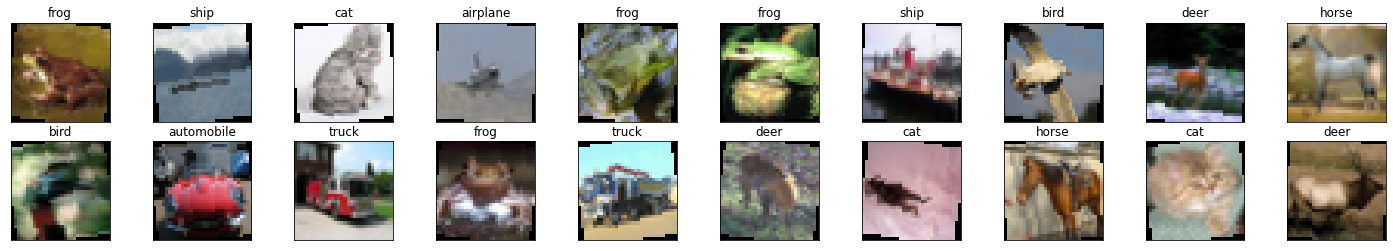

In [ ]:
images, labels = next(iter(train_loader))

fig = plt.figure(figsize = (25, 4))
print(images.shape)
for ii in range(20):
  ax = fig.add_subplot(2, 20/2, ii+1, xticks=[], yticks=[])
  images[ii] = images[ii]/2 + 0.5
  ax.imshow(np.transpose(images[ii], (1, 2, 0)))
  ax.set_title(str(classes[labels[ii]]))

In [ ]:
class Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
    self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
    self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
    self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
    self.pool = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(128 * 2 * 2, 500)
    self.fc2 = nn.Linear(500, 300)
    self.fc3 = nn.Linear(300, 100)
    self.fc4 = nn.Linear(100, 10)
    self.dropout = nn.Dropout(p = 0.2)
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    x = self.pool(F.relu(self.conv4(x)))
    x = x.view(-1, 128 * 2 * 2)
    x = self.dropout(F.relu(self.fc1(x)))
    x = self.dropout(F.relu(self.fc2(x)))
    x = self.dropout(F.relu(self.fc3(x)))
    x = self.fc4(x)
    return x
model = Classifier()  
print(model)

Classifier(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=100, bias=True)
  (fc4): Linear(in_features=100, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

In [ ]:
train_loss_list, validation_loss_list = [], []
validation_loss_min = np.Inf
epochs = 50
for e in range(epochs):
  train_loss = 0
  for images, labels in train_loader:
    optimizer.zero_grad()
    output = model(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()

  train_loss_avg = train_loss/len(train_loader)
  train_loss_list.append(train_loss_avg)

  with torch.no_grad():
    model.eval()
    validation_loss = 0
    for images, labels in valid_loader:
      output = model(images)
      loss = criterion(output, labels)
      validation_loss += loss.item()
  model.train()

  validation_loss_avg = validation_loss/len(valid_loader)
  validation_loss_list.append(validation_loss_avg)

  print()
  print(f"Epoch: {e+1}/{epochs} Train Loss: {train_loss_avg:.5f} Validation Loss: {validation_loss_avg:.5f}")

  if validation_loss_avg < validation_loss_min:
    print(f"Validation Loss decreased from {validation_loss_min:.5f} ----> {validation_loss_avg:.5f}")
    torch.save(model.state_dict(), "checkpoint.pth")
    validation_loss_min = validation_loss_avg


Epoch: 1/50 Train Loss: 2.30298 Validation Loss: 2.30230
Validation Loss decreased from inf ----> 2.30230

Epoch: 2/50 Train Loss: 2.30246 Validation Loss: 2.30234

Epoch: 3/50 Train Loss: 2.30154 Validation Loss: 2.30015
Validation Loss decreased from 2.30230 ----> 2.30015

Epoch: 4/50 Train Loss: 2.28370 Validation Loss: 2.20336
Validation Loss decreased from 2.30015 ----> 2.20336

Epoch: 5/50 Train Loss: 2.08803 Validation Loss: 1.99604
Validation Loss decreased from 2.20336 ----> 1.99604

Epoch: 6/50 Train Loss: 1.92791 Validation Loss: 1.85050
Validation Loss decreased from 1.99604 ----> 1.85050

Epoch: 7/50 Train Loss: 1.83117 Validation Loss: 1.71705
Validation Loss decreased from 1.85050 ----> 1.71705

Epoch: 8/50 Train Loss: 1.69122 Validation Loss: 1.58587
Validation Loss decreased from 1.71705 ----> 1.58587

Epoch: 9/50 Train Loss: 1.57772 Validation Loss: 1.47735
Validation Loss decreased from 1.58587 ----> 1.47735

Epoch: 10/50 Train Loss: 1.47671 Validation Loss: 1.35674

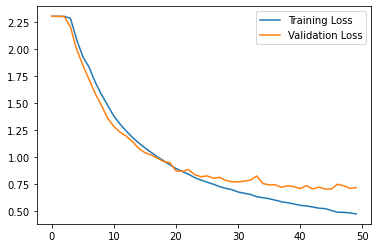

In [ ]:
plt.plot(train_loss_list, label = "Training Loss")
plt.plot(validation_loss_list, label = "Validation Loss")
plt.legend()
plt.show()

In [ ]:
test_loss = 0.0
class_correct = list(0 for i in range(10))
class_total = list(0 for i in range(10))
for images, labels in test_loader:
  output = model(images)
  loss = criterion(output, labels)
  test_loss += loss.item()
  _, pred = torch.max(output, 1)
  correct = np.squeeze(pred.eq(labels.view(*pred.shape)))
  for ii in range(images.shape[0]):
    l = labels[ii].item()
    class_correct[l] += correct[ii].item()
    class_total[l] += 1
test_loss_avg = test_loss/len(test_loader)
print(f"Test Loss: {test_loss_avg:.6f}")

for i in range(10):
  if class_total[i] > 0:
    print(f"Test Accuracy for class {classes[i]} is: {class_correct[i]/class_total[i]*100:.3f}% ({class_correct[i]}/{class_total[i]})")
  else:
    print(f"No training examples for class {i}")
print()
print(f"Total accuracy of all classes combined: {np.sum(class_correct)/np.sum(class_total)*100:.3f}% ({np.sum(class_correct)}/{np.sum(class_total)})")

Test Loss: 0.772547
Test Accuracy for class airplane is: 76.600% (766/1000)
Test Accuracy for class automobile is: 82.000% (820/1000)
Test Accuracy for class bird is: 63.100% (631/1000)
Test Accuracy for class cat is: 59.900% (599/1000)
Test Accuracy for class deer is: 69.000% (690/1000)
Test Accuracy for class dog is: 65.900% (659/1000)
Test Accuracy for class frog is: 85.200% (852/1000)
Test Accuracy for class horse is: 77.100% (771/1000)
Test Accuracy for class ship is: 88.900% (889/1000)
Test Accuracy for class truck is: 87.900% (879/1000)

Total accuracy of all classes combined: 75.560% (7556/10000)


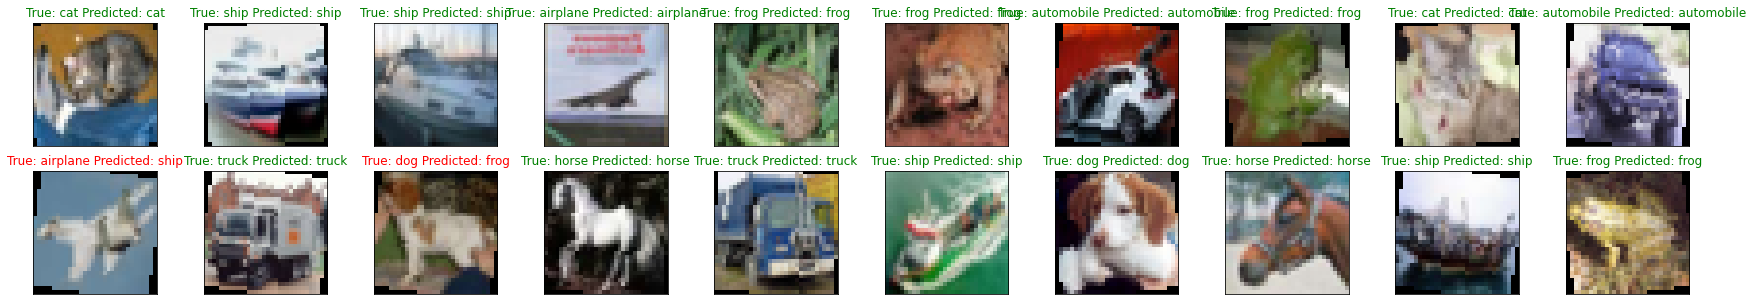

In [ ]:
images, labels = next(iter(test_loader))

output = model(images)
_, pred = torch.max(output, 1)
fig = plt.figure(figsize = (30, 5))

for i in range(images.shape[0]):
  ax = fig.add_subplot(2, 20/2, i + 1, xticks = [], yticks = [])
  images[i] = images[i]/2 + 0.5
  ax.imshow(np.transpose(images[i], (1, 2, 0)))
  ax.set_title(f"True: {str(classes[labels[i].item()])} Predicted: {str(classes[pred[i].item()])}", color = ("green" if labels[i].item() == pred[i].item() else "red"))